In [1]:
# public library imports
import pandas as pd
import os
import numpy as np
print("Current directory:", os.getcwd())
import sys
sys.path.append('.')
import torch
from collections import deque
from tqdm import tqdm
import os
import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import clear_output

# own imports  
from MDQN import ReplayBuffer, M_DQN_Agent
from Trading_Simulator import TradingEnvironment
from Residual_Generator import PCA
from Signal_Extractor import FourierExtractor, CNNTransformerExtractor

%reload_ext autoreload
%autoreload 2

Current directory: /Users/quintengeerts/Desktop/master thesis/stat_arb_thesis/empirical_analysis


In [2]:
filename = 'price_df.csv'
if os.path.exists(filename):
    price_df = pd.read_csv(filename)
    price_df = price_df.rename(columns={'Unnamed: 0':'date'})
    price_df.set_index('date', inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

price_df = price_df.loc[dt.datetime(1998,1,1):].dropna(axis=0, thresh=300)

### 1) Backwards test with fourier signal extractor

In [3]:
action_to_portfolio = {0:-1, 1:0, 2: 1}

 Episode: 11 -- Annualized Return: -1.76% -- Annualized Volatility: 1.77% -- Annualized Sharpe: -0.99
 Episode: 11 -- Total ann. Return: 2.42% -- Total ann. Volatility: 2.56% -- Total ann. Sharpe: 0.95
Episode 12	Frame 1200 	Average Score: 0.01

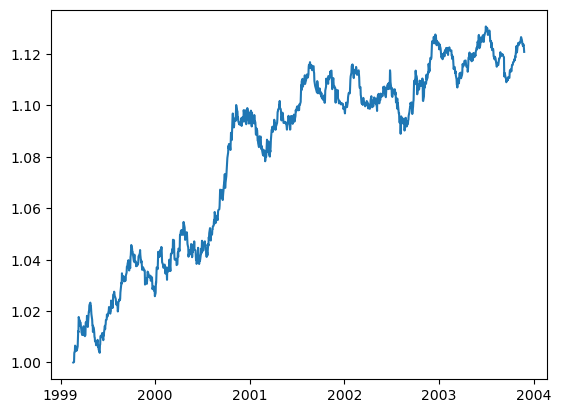

KeyboardInterrupt: 

In [23]:
# PARAMETERS
seed = 100  #np.random.randint(0,100000)

frames      = 6200
BUFFER_SIZE = 1000000
BATCH_SIZE  = 64
GAMMA       = 0.99
TAU         = 1e-2
eps_frames  = 5000
min_eps     = 0.025
LR          = 1e-3
UPDATE_EVERY= 5
n_step      = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)

action_size       = 3
state_size        = [30]

agent = M_DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        layer_size=64,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed)

##########################

MINIMUM_BUFFER  = 5000      # minimum amount of experiences before the DRL agent starts learning
EPISODE_LENGTH  = 100       # episode length, only used for telling when to show the performance
LOOKBACK_WINDOW = 252       # lookback window used for the PCA estimation
LOADING_WINDOW  = 60        # last 30 values are used to create the loadings for the factor model
FACTORS         = 5         # the amount of factors used in the factor model
SIGNAL_WINDOW   = 30        # the length of the window used for extracting the signal
TRANS_COST      = 0.0       # transaction cost for changes in the portfolio
SHORT_COST      = 0.0       # cost of keeping a short position open
WARMUP_TIME     = 0         # time needed to run the factor models before starting the strategy
RETRAIN_EVERY   = 250       # time before the feature extractor is retrained on new data

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=PCA,
                        episode_length=EPISODE_LENGTH,
                        lookback_window=LOOKBACK_WINDOW,
                        loading_window=LOADING_WINDOW,
                        signal_window=SIGNAL_WINDOW,
                        factors=FACTORS,
                        transaction_costs=TRANS_COST,
                        short_cost=SHORT_COST)

signal_extractor = FourierExtractor(signal_window=SIGNAL_WINDOW)

buffer           = ReplayBuffer(buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE,
                                device=device,
                                seed=seed,
                                gamma=GAMMA,
                                n_step=1)

state, _ = env.warm_up(warmup_time=WARMUP_TIME)
signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date])
features = state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray
features = signal_extractor.extract(features)

# INITIALISING SOME VARIABLES
score = 1
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

#training loop
for frame in range(1, frames+1):

    action = agent.act_para(features, eps)
    portfolio_allocations = np.vectorize(action_to_portfolio.get)(action) #actions need to be turned into allocations
    next_state, reward, done, info = env.step(portfolio_allocations.T)
    
    # ADD TO BUFFER 
    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], state[ticker].values, True)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], next_state[ticker].values, False)

        # DEEP REINFORCEMENT LEARNING UPDATE
        if len(buffer) > MINIMUM_BUFFER and idx % UPDATE_EVERY == 0:
            experiences = buffer.sample()
            # extract the features using the current feature extractor
            states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer = experiences
            features_buffer      = torch.FloatTensor(signal_extractor.extract(states_buffer))
            next_features_buffer = torch.FloatTensor(signal_extractor.extract(next_states_buffer))
            experiences          = (features_buffer, actions_buffer, rewards_buffer, next_features_buffer, dones_buffer)
            # perform a learning stepre
            agent.learn(experiences)

    # FEATURE EXTRACTOR RETRAINING
    if frame % RETRAIN_EVERY == 0:
        signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date]) 
    
    state     = next_state
    features  = next_state[env.tradeable_tickers].values.T
    features = signal_extractor.extract(features)

    score *= (env.p_l + 1)
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)
    
    if frame % EPISODE_LENGTH == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1 

In [73]:
env.total_pl.to_csv('results_pl.csv')
env.res_rets.to_csv('res_rets.csv')
env.res_alloc.to_csv('res_alloc.csv')

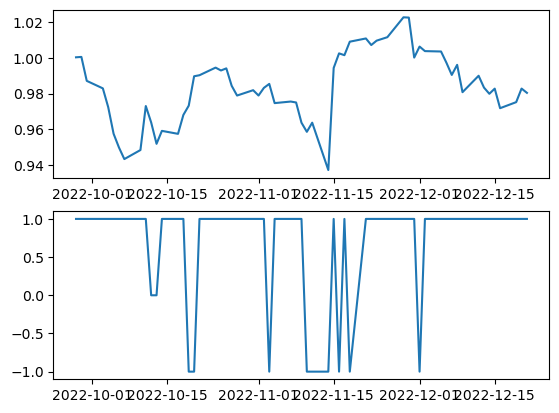

In [32]:
stock = 'WMT'
residual_test = (env.res_rets[stock].dropna().tail(60)+1).cumprod()
alloc_test    = env.res_alloc[stock].dropna().tail(60)
fig, ax  = plt.subplots(2,1)
ax[0].plot(residual_test)
ax[1].plot(alloc_test)

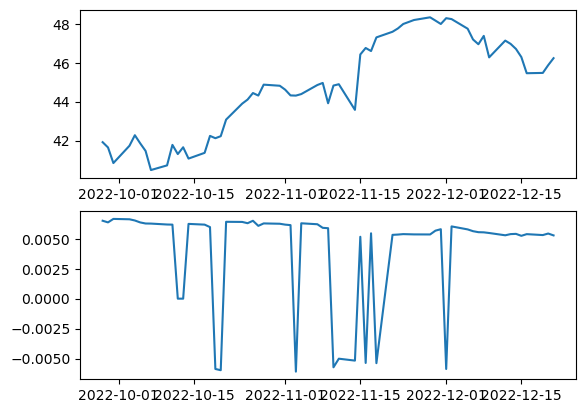

In [33]:
alloc_test    = env.asset_alloc[stock].dropna().tail(60)
residual_test = (env.data.loc[alloc_test.index,stock])
fig, ax  = plt.subplots(2,1)
ax[0].plot(residual_test)
ax[1].plot(alloc_test)

### 2) Backward test with CNN+Transformer as signal extractor

 Episode: 2 -- Annualized Return: 3.03% -- Annualized Volatility: 1.77% -- Annualized Sharpe: 1.71
 Episode: 2 -- Total ann. Return: 4.83% -- Total ann. Volatility: 2.82% -- Total ann. Sharpe: 1.71
Episode 3	Frame 300 	Average Score: 0.02

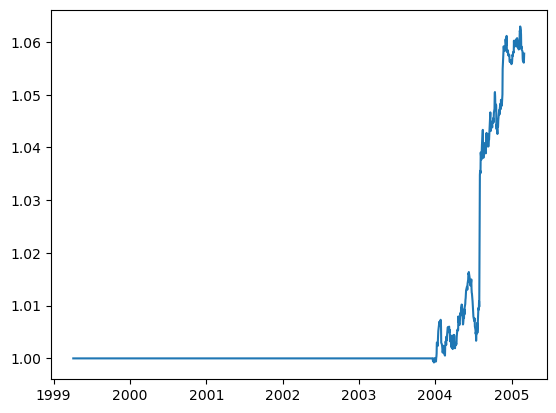

In [50]:
# PARAMETERS
seed = 100  #np.random.randint(0,100000)

frames      = 6200
BUFFER_SIZE = 1000000
BATCH_SIZE  = 64
GAMMA       = 0.99
TAU         = 1e-2
eps_frames  = 5000
min_eps     = 0.025
LR          = 1e-3
UPDATE_EVERY= 5
n_step      = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)

action_size       = 3
state_size        = [8]

agent = M_DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        layer_size=8,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed)

##########################

MINIMUM_BUFFER  = 5000      # minimum amount of experiences before the DRL agent starts learning
EPISODE_LENGTH  = 100       # episode length, only used for telling when to show the performance
LOOKBACK_WINDOW = 252       # lookback window used for the PCA estimation
LOADING_WINDOW  = 60        # last 30 values are used to create the loadings for the factor model
FACTORS         = 5         # the amount of factors used in the factor model
SIGNAL_WINDOW   = 60        # the length of the window used for extracting the signal
TRANS_COST      = 0.0       # transaction cost for changes in the portfolio
SHORT_COST      = 0.0       # cost of keeping a short position open
WARMUP_TIME     = 1500      # time needed to run the factor models before starting the strategy
RETRAIN_EVERY   = 1000000   # time before the feature extractor is retrained on new data

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=PCA,
                        episode_length=EPISODE_LENGTH,
                        lookback_window=LOOKBACK_WINDOW,
                        loading_window=LOADING_WINDOW,
                        signal_window=SIGNAL_WINDOW,
                        factors=FACTORS,
                        transaction_costs=TRANS_COST,
                        short_cost=SHORT_COST)

signal_extractor = CNNTransformerExtractor(signal_window=SIGNAL_WINDOW)

buffer           = ReplayBuffer(buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE,
                                device=device,
                                seed=seed,
                                gamma=GAMMA,
                                n_step=1)

state, _ = env.warm_up(warmup_time=WARMUP_TIME)
signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date])
features = state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray
features = signal_extractor.extract(features)

# INITIALISING SOME VARIABLES
score = 1
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

#training loop
for frame in range(1, frames+1):

    action = agent.act_para(features, eps)
    portfolio_allocations = np.vectorize(action_to_portfolio.get)(action) #actions need to be turned into allocations
    next_state, reward, done, info = env.step(portfolio_allocations.T)
    
    # ADD TO BUFFER 
    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], state[ticker].values, True)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], next_state[ticker].values, False)

        # DEEP REINFORCEMENT LEARNING UPDATE
        if len(buffer) > MINIMUM_BUFFER and idx % UPDATE_EVERY == 0:
            experiences = buffer.sample()
            # extract the features using the current feature extractor
            states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer = experiences
            features_buffer      = torch.FloatTensor(signal_extractor.extract(states_buffer))
            next_features_buffer = torch.FloatTensor(signal_extractor.extract(next_states_buffer))
            experiences          = (features_buffer, actions_buffer, rewards_buffer, next_features_buffer, dones_buffer)
            # perform a learning step
            agent.learn(experiences)

    # FEATURE EXTRACTOR RETRAINING
    if frame % RETRAIN_EVERY == 0:
        signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date]) 
    
    state     = next_state
    features  = next_state[env.tradeable_tickers].values.T
    features = signal_extractor.extract(features)

    score *= (env.p_l + 1)
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)
    
    if frame % EPISODE_LENGTH == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1 